# Лабораторная работа "Неодимовый лазер"

## В  настоящем блокноте представлена  программа для  выполнения следующих задач:<br>
### 1) Измерение времени жизни верхнего рабочего уровня 
### 2) Измерение времмени жизни фотона в резонаторе и первышения усиления над потерями 
### 3)   Измерение порога генерации

In [59]:

import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, peak_widths,savgol_filter
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import copy
import math
from scipy.stats import t

In [2]:
data_path =  "Neodymium_lab_data"
save_path = "results"

In [3]:
def unpack(path, mod): 
    file = open(path + "\\" + mod + ".txt", 'r' )
    data = file.readlines()
    data = [line.rstrip().split(",") for line in data]
    settings = data[:4]
    del data[:5]
    data = np.array(data).astype("float")
    time = data[:,0]
    signal = data[:, 1]
    return  settings, time, signal

def find_max(data, prominence, distance):
    max_ind = find_peaks(data[1],  prominence =  prominence, distance = distance)
    return [data[0][max_ind[0]],data[1][max_ind[0]], max_ind[0] ]


In [4]:
mod = ["lifetime", "relax"]

Выполним первое задание 
### Измерение времени жизни верхнего рабочего уровня 

In [5]:
settings_lt, time_lt, signal_lt = unpack(data_path,"lifetime" )
#сдвинем время на 0 для удобства
time_lt =  time_lt -  time_lt[0]

Кристалл накачивался импульсно, длительность которого много больше времени жизни рабочего уровня. Чтобы определить время жизни верхнего уровня нужно апроксимировать сигнал сразу после выключения одного из импульсов  накачки экспонентой, число, обратное коэффициенту в показателе, будет нашим временем жизни.

Получим эту экспоненту $a\cdot e^{b\cdot t}$ В функцию curve_fit необходимо передавать такой срез, чтобы плато перед спадом не попадало в него, в нашем случае это все значения после 6000 индекса  

In [6]:
[a,b],cov = curve_fit(lambda x1,a, b: a*np.exp(b*x1),  time_lt[6000:],  signal_lt[6000:], maxfev=5000)
Delta_a, Delta_b = np.sqrt(np.diag(cov))

Весь сигнал  c аппроксимирующей кривой будет выглядеть так:

In [7]:
time_coef = 1e+3
ampl_coef = 1e+3

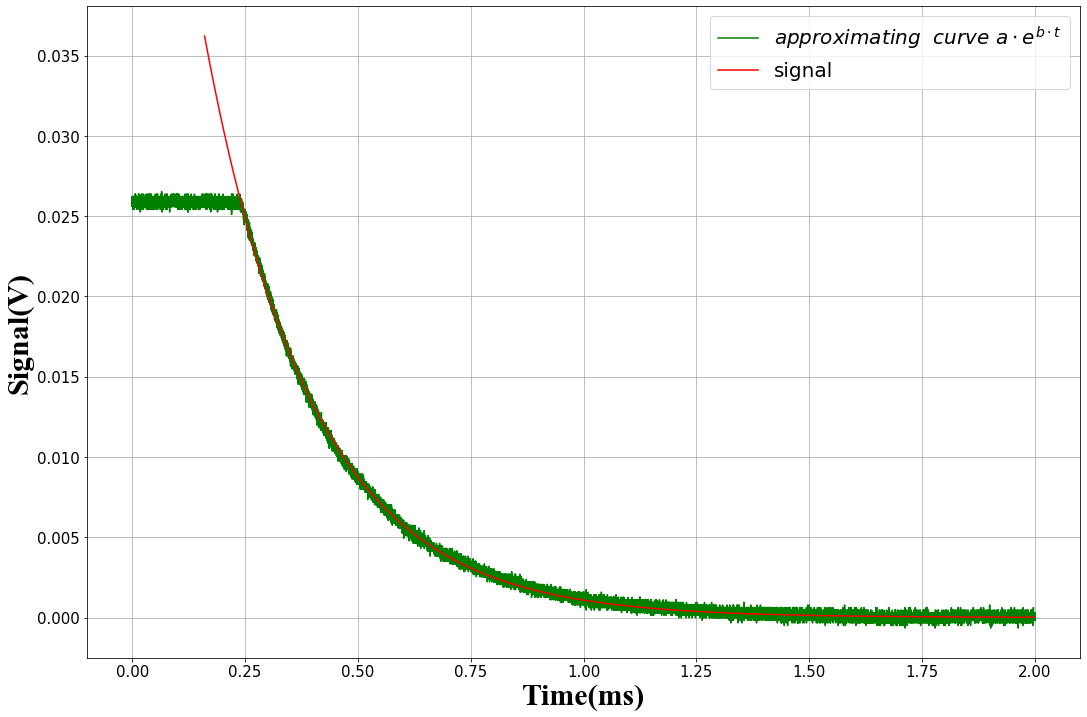

In [8]:

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time_lt * time_coef,  signal_lt, c = 'g',label = "$approximating~~curve~a\cdot e^{b\cdot t}$") 
ax.plot(time_lt[4000:]* time_coef, a*np.exp(b*time_lt[4000:]), c = 'r', label = "signal") 
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Signal(V)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.legend(fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.grid()
plt.savefig(save_path + "\\" + "full_graph_lifetime.jpg")

Коэффициент b найден $\Rightarrow~~ \tau_{life} = \frac{1}{b} ~~~~~~~~~~~~~\Delta \tau_{life} = \tau_{life}\cdot \frac{\Delta b}{b} = \tau_{life}\cdot \delta b $ 

In [9]:
tau_life = abs(1 / b) 
Delta_tau_life = tau_life*abs(Delta_b/b)
delta_tau = Delta_tau_life / tau_life

Результат,который лучше выписать отдельно<br>
$\tau_{life}~=~239.15\pm 6 мкc~~~~~~~~ \epsilon~=~ 0.02\%$


### Измерение времмени жизни фотона в резонаторе и первышения усиления над потерями 

In [10]:
settings_relax, time_relax, signal_relax = unpack(data_path,"relax" )
#сдвинем время на 0 для удобства
time_relax =  time_relax -  time_relax[0]

Время жизни фотона в резонаторе можно определить как  число, обратное показателю экспоненты, которая является огибающей к релаксационным колебаниям. Поэтому сначала найдем точки максимумов колебаний, аппроксимируем их экспонентой и возьмём число, обратное показателю этой экспоненты -- Да хуй там плавал, по экспоненте мы определяем время затухания. Уже по нему мы определяем превышение усиления над потерями. Измерив период релаксационных колебаний мы узнаем время жизни фотона, руководствуясь формулами, которые являются следствием модели Статса-де-Марса: 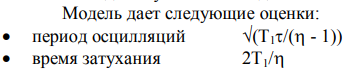


Найдём точки максимумов

In [11]:
 max_time_relax, max_signal_relax, max_ind_relax = find_max(
                                                             [time_relax, signal_relax], 
                                                              prominence = 0.02,
                                                              distance = 20
                                                             )

In [33]:
#[d_0],cov_0 = curve_fit(lambda x, d: np.exp(d*x),   max_time_relax,  max_signal_relax, maxfev=5000)
#print(d_0,cov_0, np.sqrt(cov_0))
#Delta_d_0 = np.sqrt(cov_0)
#approx_relax_time_0 = np.linspace(0, max(time_relax),12000) 


-16624.794098448332 [[1819990.91768736]] [[1349.07039019]]


In [25]:
#tau_relax_0 = abs(1 / d_0)
#Delta_tau_relax_0 = tau_relax_0* abs(Delta_d_0 / d_0)
#delta_tau_relax_0 = Delta_tau_relax_0 / tau_relax_0
#print(tau_relax_0, Delta_tau_relax_0, delta_tau_relax_0)

6.015112091483494e-05 [[4.88114894e-06]] [[0.0811481]]


Если использовать аппроксимацию экспонентой без коэффицента с, то значение $\tau_{relax}~=~60\pm 5 мкc~~~~~~~~ \epsilon~=~8\%$ - хуйня

Конечно, это всё еще большое значение, но оно уже меньше $\tau_{life}$


Аппроксимируем их экспонентой

In [26]:
[c,d],cov_1 = curve_fit(lambda x,c, d: c*np.exp(d*x),   max_time_relax,  max_signal_relax, maxfev=5000)
print([c,d],cov_1, np.diag(cov_1), np.sqrt(np.diag(cov_1)))
Delta_c, Delta_d = np.sqrt(np.diag(cov_1))
approx_relax_time = np.linspace(0, max(time_relax),12000) 


[0.2914201717889449, -2823.7137301002817] [[ 6.24460667e-04 -1.54111059e+01]
 [-1.54111059e+01  4.60570296e+05]] [6.24460667e-04 4.60570296e+05] [2.49892110e-02 6.78653296e+02]


Посчитаем время жизни фотона в резонаторе  равное характерному времени релаксации 


In [27]:
tau_relax = abs(1 / d)
Delta_tau_relax = tau_relax* abs(Delta_d / d)
delta_tau_relax = Delta_tau_relax / tau_relax
print(tau_relax, Delta_tau_relax, delta_tau_relax)

0.0003541435483845899 8.51151034654318e-05 0.24034068629424585


Результат,который лучше выписать отдельно<br>
$\tau_{att}~=~380\pm 80 мкc~~~~~~~~ \epsilon~=~ 24\%$ - время затухания

Определим превышение усиления над потерями $\eta_{att} = 2\tau_{life}/\tau_{att} ~=~ (13\pm 3)*10^{-1} ~~~~~~\epsilon~=~ 23\%$

In [42]:
time_coef = 1e+3
right_range = 9000

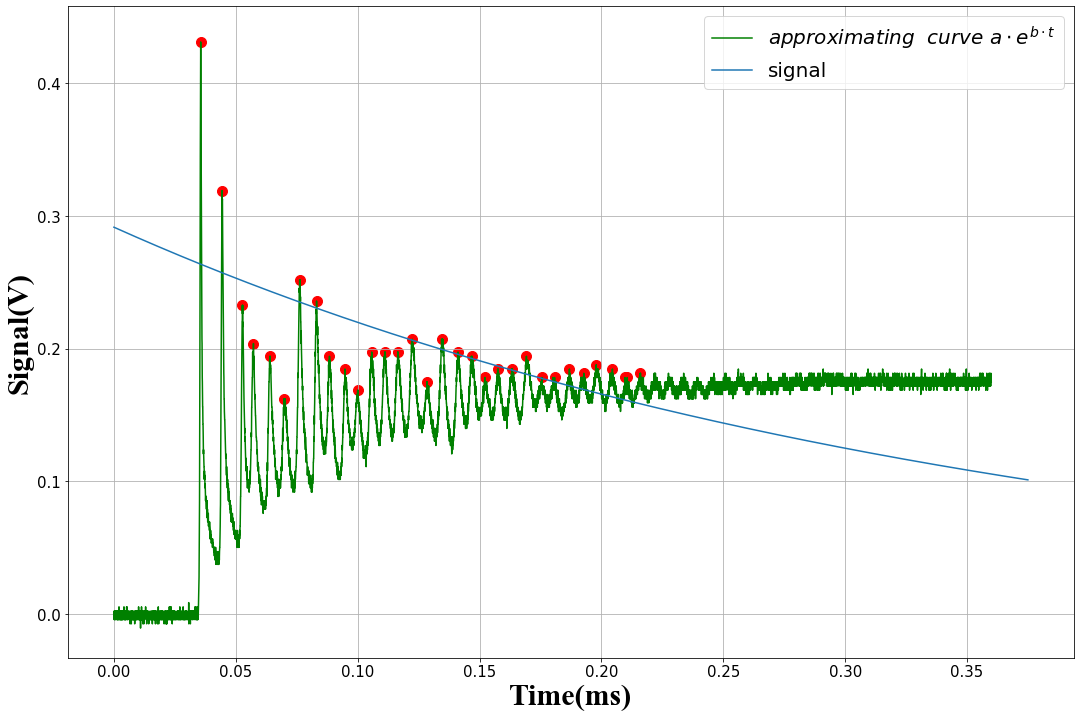

In [34]:
#первичный график
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Signal(V)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.plot(time_relax[:right_range]*time_coef,  signal_relax[:right_range], c = 'g',label = "$approximating~~curve~a\cdot e^{b\cdot t}$") 
ax.plot(approx_relax_time[:right_range]*time_coef, c*np.exp(d*approx_relax_time)[:right_range], label = "signal")
for i in range(len(max_ind_relax)):
    ax.scatter(max_time_relax[i]*time_coef, max_signal_relax[i],color='red', s=100, marker='o'  )
ax.legend(fontsize=20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.grid()

##Место для отношения сигнал/потери

Нужно найти период релаксационных колебаний вблизи стационарного режима

0.005469999812499999
0.0012696848216193384


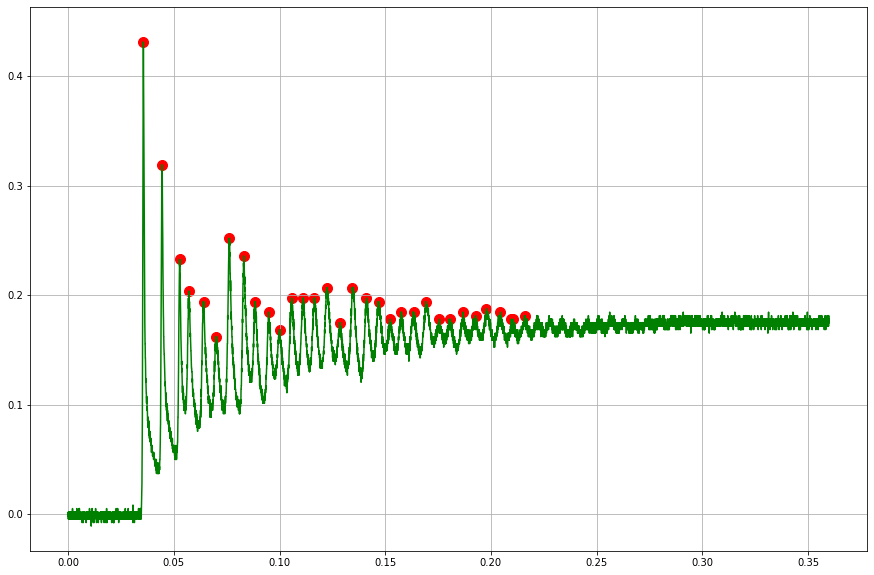

In [64]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
for i in range(len(max_ind_relax)):
    ax.scatter(max_time_relax[i]*time_coef, max_signal_relax[i],color='red', s=100, marker='o'  )
ax.plot(time_relax[:right_range]*time_coef,  signal_relax[:right_range], c = 'g',label = "$approximating~~curve~a\cdot e^{b\cdot t}$")
ax.grid()
Period_relax = [(max_time_relax[i] - max_time_relax[i-1])*time_coef for i in range(len(max_ind_relax)//2,len(max_ind_relax))]
print(np.average(Period_relax))
print(np.std(Period_relax))

То есть средний период релаксационных колебаний T = (55$\pm$13)*10^-1 mсs 

Рассчитаем время жизни фотона в резонаторе 

$\tau_{life} = (4 \pm 2)*10 ~~~~~ns~~~~ \epsilon~=~ 50\%$